In [43]:
import matplotlib.pyplot as plt
import pandas as pd
import re

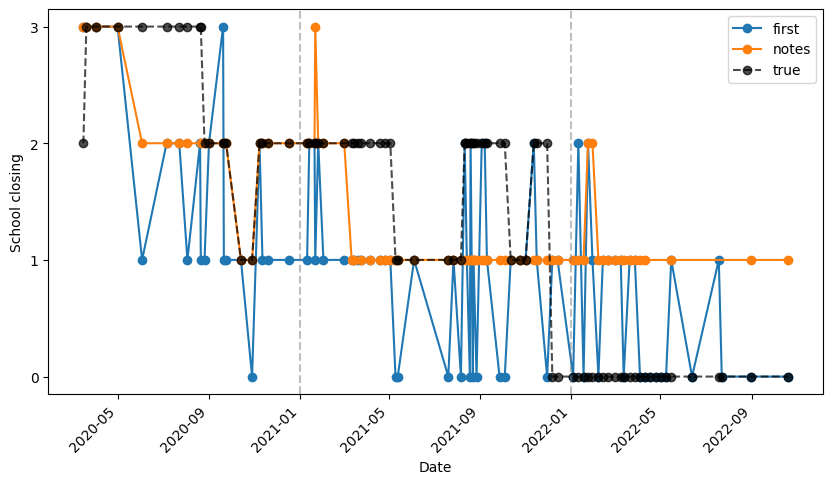

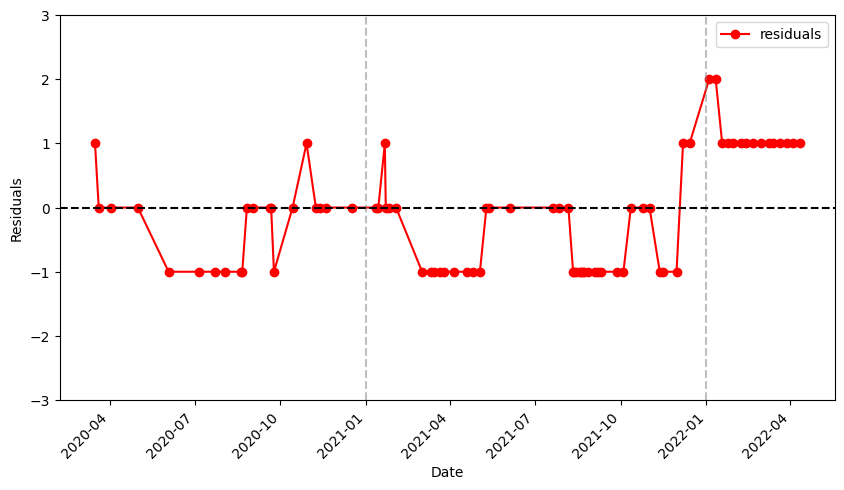

In [ ]:
def compare_results(results_dirs: dict[str, str]):

    fig, ax = plt.subplots(figsize=(10, 5))

    labels = pd.read_csv("texas-labels.csv")
    labels["Date"] = pd.to_datetime(labels["Date"])
    labels = labels.sort_values(by="Date")
    labels["Score"] = labels["Score"].astype(int)

    for label, path in results_dirs.items():
        preds = pd.read_csv(path)
        preds["Date"] = pd.to_datetime(preds["Date"])
        preds = preds.sort_values(by="Date")

        preds["Score"] = preds["Score"].fillna("0")
        preds["Score"] = preds["Score"].astype(str)
        valid_scores = ["0", "1", "2", "3"]
        # any score not in valid scores should be set to 0
        preds["Score"] = preds["Score"].apply(lambda x: x if x in valid_scores else "0")
        preds["Score"] = preds["Score"].astype(int)
        ax.plot(preds["Date"], preds["Score"], marker="o", label=label)

    ax.plot(labels["Date"], labels["Score"], marker="o", color="black", linestyle="--", alpha=0.7, label="true")

    ax.axvline(pd.to_datetime("2021-01-01"), color="gray", linestyle="--", alpha=0.5)
    ax.axvline(pd.to_datetime("2022-01-01"), color="gray", linestyle="--", alpha=0.5)

    ax.legend()
    ax.set_xlabel("Date")
    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_yticks([0, 1, 2, 3])
    ax.set_ylabel("School closing")

    plt.show()

    # residuals = preds["Score"] - labels["Score"]
    # fig, ax = plt.subplots(figsize=(10, 5))
    # ax.plot(labels["Date"], residuals, marker="o", color="red", label="residuals")

    # ax.axvline(pd.to_datetime("2021-01-01"), color="gray", linestyle="--", alpha=0.5)
    # ax.axvline(pd.to_datetime("2022-01-01"), color="gray", linestyle="--", alpha=0.5)
    # ax.axhline(0, color="black", linestyle="--")

    # ax.legend()
    # ax.set_xlabel("Date")
    # ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
    # ax.set_yticks([-3, -2, -1, 0, 1, 2, 3])
    # ax.set_ylabel("Residuals")

    # plt.show()


compare_results({"first": "../logs/first-run/persistence.csv", "notes": "persistence.csv"})

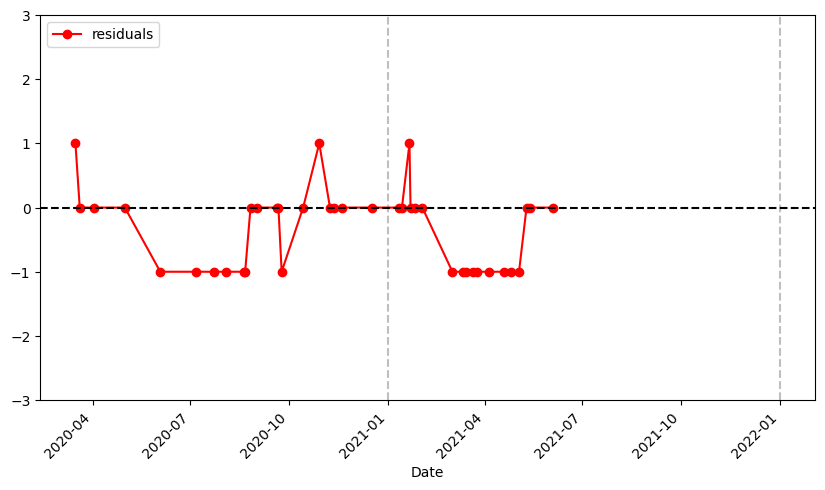

In [ ]:
def plot_residuals():
    labels = pd.read_csv("texas-labels.csv")
    preds = pd.read_csv("persistence.csv")

    labels["Date"] = pd.to_datetime(labels["Date"])
    preds["Date"] = pd.to_datetime(preds["Date"])

    labels = labels.sort_values(by="Date")
    preds = preds.sort_values(by="Date")

    preds["Score"] = preds["Score"].fillna(0)
    preds["Score"] = preds["Score"].astype(int)
    valid_scores = [0, 1, 2, 3]
    # any score not in valid scores should be set to 0
    preds["Score"] = preds["Score"].apply(lambda x: x if x in valid_scores else 0)
    labels["Score"] = labels["Score"].astype(int)

    resid = preds["Score"] - labels["Score"]

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(labels["Date"], resid, marker="o", color="red", label="residuals")

    ax.axvline(pd.to_datetime("2021-01-01"), color="gray", linestyle="--", alpha=0.5)
    ax.axvline(pd.to_datetime("2022-01-01"), color="gray", linestyle="--", alpha=0.5)
    ax.axhline(0, color="black", linestyle="--")

    ax.legend()
    ax.set_xlabel("Date")
    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
    
    
    plt.show()

plot_residuals()


In [ ]:
df = pd.read_csv("OxCGRT_raw_USA_v1.csv")

In [ ]:
for col in df.columns:
    print(col)

In [ ]:
c1_cols = ["C1E_School closing", "C1_Notes"]
index_cols = ["CountryName", "CountryCode", "RegionName", "RegionCode", "Date"]
c1 = df[index_cols + c1_cols]
c1 = c1[c1["RegionName"] == "Texas"]
c1 = c1.dropna(subset=c1_cols)
c1["Date"] = pd.to_datetime(c1["Date"], format="%Y%m%d")
c1 = c1.sort_values(by=["Date"])
len(c1)

In [ ]:
def get_notes_from_date(c1: pd.DataFrame, date: str) -> str:
    date = pd.to_datetime(date, format="%Y-%m-%d")
    subset = c1[c1["Date"] == date]
    notes = subset["C1_Notes"].tolist()[0]
    score = subset["C1E_School closing"].tolist()[0]
    return score, notes

In [ ]:
get_notes_from_date(c1, "2022-01-11")

In [ ]:
def extract_urls(text: str) -> list[str]:
    url_pattern = r'https?://[^\s<>"]+|www\.[^\s<>"]+'
    urls = re.findall(url_pattern, text)
    return urls

def create_dataset(c1: pd.DataFrame) -> pd.DataFrame:
    policy = "C1E_School closing"
    region = "Texas"
    data = []
    for i, row in c1.iterrows():
        date = pd.to_datetime(row["Date"], format="%Y%m%d").date()
        score = row[policy]
        print(row["C1_Notes"])
        urls = extract_urls(row["C1_Notes"])
        url_string = ", ".join(urls)
        to_add = {"Date": date, "Region": region, "Policy": policy, "Score": score, "source": url_string}
        data.append(to_add)

    df = pd.DataFrame(data)
    return df

texas = create_dataset(c1)
# texas.drop(columns=["Score"]).to_csv("texas.csv", index=False)
# texas.drop(columns=["source"]).to_csv("texas-labels.csv", index=False)

In [ ]:
fig, ax = plt.subplots()
ax.plot(pd.to_datetime(texas["Date"], format="%Y%m%d"), texas["Score"])
ax.set_xlabel("Date")
ax.set_ylabel("C1E_School closing")
plt.show()